In [1]:
# Allows us to import packages that exist one level up in the file system
# See https://stackoverflow.com/questions/34478398
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path = [module_path] + sys.path

In [2]:
from tagnews.utils import load_data as ld
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.feature_extraction.text
import sklearn.multiclass
import sklearn.linear_model
% matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

In [3]:
df = ld.load_data()

/home/kevin/miniconda3/envs/cjp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (3,10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Article Tags Exploration

In [4]:
print('# total articles       :', df.shape[0])
print('# tagged articles      :', df.loc[:, 'OEMC':'TASR'].any(1).sum())
print('# not relevant articles:', (~df['relevant']).sum())
print('# w/ no information    :', df.shape[0] - df.loc[:, 'OEMC':'TASR'].any(1).sum() - (~df['relevant']).sum())

# this number should be 0, but it isn't...
print('\n# articles tagged but not relevant :', (~df['relevant'] & df.loc[:, 'OEMC':'TASR'].any(1)).sum())

# total articles       : 357901
# tagged articles      : 37702
# not relevant articles: 167268
# w/ no information    : 152931

# articles tagged but not relevant : 2737


In [5]:
categories_df = ld.load_categories()
categories_df = categories_df.loc[:, ['abbreviation', 'category_name']]
categories_df.set_index('abbreviation', drop=True, inplace=True)

categories_df['counts'] = df.loc[:, 'OEMC':'TASR'].apply(sum, reduce=True)
categories_df.sort_values(by='counts')

,category_name,counts
abbreviation,,
ENVI,Environmental Crimes,49.0
TASR,Police Use of Taser,120.0
OEMC,Office of Emergency Management & Communications,127.0
REEN,Re-Entry,130.0
CPBD,Chicago Police Board,155.0
ILSC,Illinois State Court,179.0
CPUB,Cook County Public Defender's Office,223.0
IMMG,Immigration,227.0
IDOC,Illinois Department of Corrections,302.0


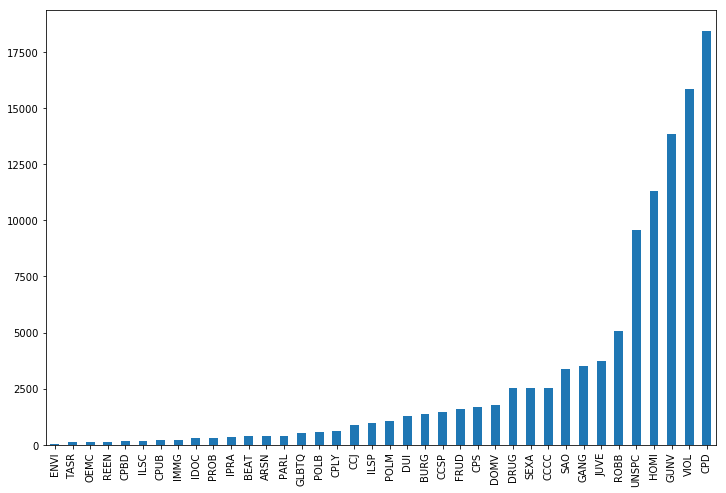

In [6]:
df.loc[:, 'OEMC':'TASR'].apply(sum, reduce=True).sort_values().plot(kind='bar');

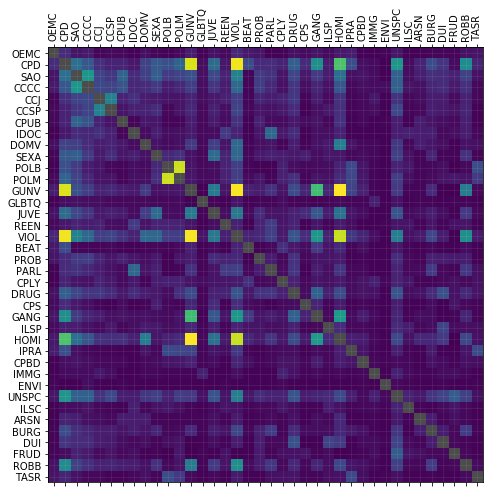

In [7]:
corrs = df.loc[:, 'OEMC':'TASR'].corr()
for i in range(corrs.shape[0]):
    corrs.iloc[i, i] = np.nan

cmap = matplotlib.cm.viridis
cmap.set_bad((.3, .3, .3),1.)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(np.ma.masked_invalid(corrs.values), cmap=cmap)

ax.grid(True, color=(.9, .9, .9), alpha=.1)

plt.xticks(range(len(corrs.columns)), corrs.columns, rotation=90);
plt.yticks(range(len(corrs.columns)), corrs.columns);

# Text Contents Exploration

In [8]:
# Print a random article just to see what they look like.
i = np.random.choice(df.shape[0])
print('ARTICLE ID:', df.index[i], '\n------------------')
print(df.iloc[i]['bodytext'])

ARTICLE ID: 326751 
------------------
** FOX NEWS ** \- The Iowa State Patrol caught a speeder going 144 mph on I-80 in the dark of night in early May. 

An image of the radar gun’s display was posted to the divison's Facebook page,
which said the unidentified car was spotted at the “blazing” speed during the
midnight shift, and added a warning to drivers that “a dark, open road is no
excuse for high speed.”

The type of car and driver’s identity were not identified, but The Des Moines
Register reports that the driver faces a $559.00 fine and possible suspension of
his or her license.

The Iowa State Patrol frequently uses Facebook to report on cars it catches
travelling at excessive speeds as a deterrent, pointing out the dangers and
punishments the drivers are subjecting themselves to.

[ ** Continue reading this story at FOXNews.com ** ][1]

   [1]: http://www.foxnews.com/auto/2017/05/30/iowa-police-catch-speeder-
going-144-mph.html


## Some questions:

* How to handle articles that talk about more than one crime (i.e. a summary of weekend violence)?
* Would we want the scraper to keep any more information going forward? Author name, for example?
* Do we want to have manually-defined cleaning built around the format? I.e. specifically remove the links at the bottom that are result of RSS format? 